In [6]:
import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dropout

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity as cosine
import joblib as jl


from tensorflow.keras import models
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import pandas as pd
import os

# Used to one hot encode the cities
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sn

In [7]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [8]:
def get_question_fields(df):
    all_question_fields = df['Question_Field'].tolist()
    for i in range(len(all_question_fields)):
        all_question_fields[i] = all_question_fields[i].strip()
        if 'chem' in all_question_fields[i].lower():
            all_question_fields[i] = 'Chemistry'
        if 'phy' in all_question_fields[i].lower():
            all_question_fields[i] = 'Physics'
        if 'bio' in all_question_fields[i].lower():
            all_question_fields[i] = 'Biology'
        if 'geo' in all_question_fields[i].lower():
            all_question_fields[i] = 'Geography'
        if 'ast' in all_question_fields[i].lower():
            all_question_fields[i] = 'Astronomy'
        if 'gen' in all_question_fields[i].lower():
            all_question_fields[i] = 'General'
        if 'com' in all_question_fields[i].lower():
            all_question_fields[i] = 'Computer Science'
    print('Unique question fields found: {}'.format(len(set(all_question_fields))))
    return all_question_fields

def get_question_types(df):
    all_question_types = df['Question_Type'].tolist()
    print('Unique question types found: {}'.format(len(set(all_question_types))))
    return all_question_types

def get_encoded_question_fields(df):
    encoded_question_fields = df['one_hot_encoded_question_fields'].tolist()
    return np.asarray(encoded_question_fields)

def get_encoded_question_types(df):
    encoded_question_types = df['one_hot_encoded_question_types'].tolist()
    return np.asarray(encoded_question_types)

def get_actual_question_tokens(df):
    
    train_tokens = df["actual_question_tokens"].tolist()
    
    return np.array(train_tokens)

def get_correct_statement_tokens(df):
    
    train_tokens = df["correct_statement_tokens"].tolist()
    
    return np.array(train_tokens)

def add_one_hot_encoded_question_fields(df):
    df_temp = df.copy()
    all_question_fields = get_question_fields(df_temp)
    encoder = LabelEncoder()
    encoder.fit(all_question_fields)
    print(encoder.classes_)
    encoded_question_fields = encoder.transform(all_question_fields)
    one_hot_encoded_question_fields = to_categorical(encoded_question_fields)
    one_hot_encoded_question_fields = one_hot_encoded_question_fields.astype(int)
    one_hot_encoded_question_fields = one_hot_encoded_question_fields.tolist()
    df_temp['one_hot_encoded_question_fields'] = one_hot_encoded_question_fields
    return df_temp, encoder.classes_

def add_one_hot_encoded_question_types(df):
    df_temp = df.copy()
    all_question_types = get_question_types(df_temp)
    encoder = LabelEncoder()
    encoder.fit(all_question_types)
    encoded_question_types = encoder.transform(all_question_types)
    one_hot_encoded_question_types = to_categorical(encoded_question_types)
    one_hot_encoded_question_types = one_hot_encoded_question_types.astype(int)
    one_hot_encoded_question_types = one_hot_encoded_question_types.tolist()
    df_temp['one_hot_encoded_question_types'] = one_hot_encoded_question_types
    return df_temp

def add_actual_question_tokens(df, samples, serialize_path=None):
    """Add Tokens to dataframe
    
    """

    #  Prepare for word embeddings
    df_emb = df.copy()
    all_words = []
    for tags in df_emb['Actual_Question']:
        for word in tags.split(' '):
            all_words.append(word)
    unique_words = set(all_words)
    print(unique_words)
    print('we found {} unique words'.format(len(unique_words)))
    
    # tokenize
    tokenizer = tf.keras.preprocessing.text.Tokenizer(split=' ', lower=True, filters='')
    tokenizer.fit_on_texts(list(samples['Actual_Question']))
    padded_tokens = []
    for tags in df_emb['Actual_Question']:
        seqs = tokenizer.texts_to_sequences([tags])
        padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(seqs, 15, padding='post')
        padded_tokens.append(padded_seqs[0])
        
    if serialize_path is not None:
        jl.dump(tokenizer, serialize_path)

    # update df
    df_emb['actual_question_tokens'] = padded_tokens
    
    return df_emb

def add_correct_statement_tokens(df, samples, serialize_path=None):
    """Add Tokens to dataframe
    
    """

    #  Prepare for word embeddings
    df_emb = df.copy()
    all_words = []
    for tags in df_emb['Correct_Statement']:
        for word in tags.split(' '):
            all_words.append(word)
    unique_words = set(all_words)
    print(unique_words)
    print('we found {} unique words'.format(len(unique_words)))
    
    # tokenize
    tokenizer = tf.keras.preprocessing.text.Tokenizer(split=' ', lower=True, filters='')
    tokenizer.fit_on_texts(list(samples['Actual_Question']))
    padded_tokens = []
    for tags in df_emb['Correct_Statement']:
        seqs = tokenizer.texts_to_sequences([tags])
        padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(seqs, 5, padding='post')
        padded_tokens.append(padded_seqs[0])
        
    if serialize_path is not None:
        jl.dump(tokenizer, serialize_path)

    # update df
    df_emb['correct_statement_tokens'] = padded_tokens
    
    return df_emb

In [9]:
quiz_data = pd.read_csv('Science Quiz Data set - Questions Data.csv')

In [8]:
quiz_data.head()

,Question_Id,Actual_Question,Question_Field,Question_Type,Total_Views,Total_Answers,Total_Correct,Total_Incorrect,Correct_Statement,Incorrect_Statement,Quiz_Date,Unnamed: 11,Percent_Correct,Percent_Incorrect,Percent_Participate,Real Number,Avarage Views
0,1,What is considered neutral on the pH scale?,Chemistry,Question,191,67,61,6,a pH of 7,a pH of 0,10/05/2019,NaN,91.04%,8.96%,35.08%,1.0,126.545283
1,2,What allows electricity to flow?,Physics,Question,187,63,57,6,Conductor,Insulator,10/05/2019,NaN,90.48%,9.52%,33.69%,2.0,126.545283
2,3,What element is a diamond made of?,Chemistry,Question,179,63,53,10,Carbon,Silicon,10/05/2019,NaN,84.13%,15.87%,35.20%,3.0,126.545283
3,4,How do you write Giga in scientific notation,General,Question,176,61,42,19,10^9,10^12,10/05/2019,NaN,68.85%,31.15%,34.66%,4.0,126.545283
4,5,What changes as gravity changes?,Physics,Question,169,62,35,27,Weight,Mass,10/05/2019,NaN,56.45%,43.55%,36.69%,5.0,126.545283


In [10]:
quiz_data.shape

(530, 17)

In [11]:
df, classes = add_one_hot_encoded_question_fields(quiz_data)
df.head()

Unique question fields found: 7
['Astronomy' 'Biology' 'Chemistry' 'Computer Science' 'General'
 'Neurology' 'Physics']


,Question_Id,Actual_Question,Question_Field,Question_Type,Total_Views,Total_Answers,Total_Correct,Total_Incorrect,Correct_Statement,Incorrect_Statement,Quiz_Date,Unnamed: 11,Percent_Correct,Percent_Incorrect,Percent_Participate,Real Number,Avarage Views,one_hot_encoded_question_fields
0,1,What is considered neutral on the pH scale?,Chemistry,Question,191,67,61,6,a pH of 7,a pH of 0,10/05/2019,NaN,91.04%,8.96%,35.08%,1.0,126.545283,"[0, 0, 1, 0, 0, 0, 0]"
1,2,What allows electricity to flow?,Physics,Question,187,63,57,6,Conductor,Insulator,10/05/2019,NaN,90.48%,9.52%,33.69%,2.0,126.545283,"[0, 0, 0, 0, 0, 0, 1]"
2,3,What element is a diamond made of?,Chemistry,Question,179,63,53,10,Carbon,Silicon,10/05/2019,NaN,84.13%,15.87%,35.20%,3.0,126.545283,"[0, 0, 1, 0, 0, 0, 0]"
3,4,How do you write Giga in scientific notation,General,Question,176,61,42,19,10^9,10^12,10/05/2019,NaN,68.85%,31.15%,34.66%,4.0,126.545283,"[0, 0, 0, 0, 1, 0, 0]"
4,5,What changes as gravity changes?,Physics,Question,169,62,35,27,Weight,Mass,10/05/2019,NaN,56.45%,43.55%,36.69%,5.0,126.545283,"[0, 0, 0, 0, 0, 0, 1]"


In [12]:
df = add_one_hot_encoded_question_types(df)
df.head()

Unique question types found: 4


,Question_Id,Actual_Question,Question_Field,Question_Type,Total_Views,Total_Answers,Total_Correct,Total_Incorrect,Correct_Statement,Incorrect_Statement,Quiz_Date,Unnamed: 11,Percent_Correct,Percent_Incorrect,Percent_Participate,Real Number,Avarage Views,one_hot_encoded_question_fields,one_hot_encoded_question_types
0,1,What is considered neutral on the pH scale?,Chemistry,Question,191,67,61,6,a pH of 7,a pH of 0,10/05/2019,NaN,91.04%,8.96%,35.08%,1.0,126.545283,"[0, 0, 1, 0, 0, 0, 0]","[0, 0, 1, 0]"
1,2,What allows electricity to flow?,Physics,Question,187,63,57,6,Conductor,Insulator,10/05/2019,NaN,90.48%,9.52%,33.69%,2.0,126.545283,"[0, 0, 0, 0, 0, 0, 1]","[0, 0, 1, 0]"
2,3,What element is a diamond made of?,Chemistry,Question,179,63,53,10,Carbon,Silicon,10/05/2019,NaN,84.13%,15.87%,35.20%,3.0,126.545283,"[0, 0, 1, 0, 0, 0, 0]","[0, 0, 1, 0]"
3,4,How do you write Giga in scientific notation,General,Question,176,61,42,19,10^9,10^12,10/05/2019,NaN,68.85%,31.15%,34.66%,4.0,126.545283,"[0, 0, 0, 0, 1, 0, 0]","[0, 0, 1, 0]"
4,5,What changes as gravity changes?,Physics,Question,169,62,35,27,Weight,Mass,10/05/2019,NaN,56.45%,43.55%,36.69%,5.0,126.545283,"[0, 0, 0, 0, 0, 0, 1]","[0, 0, 1, 0]"


In [13]:
df = add_actual_question_tokens(df, df, './artifacts/actual_question_tokenizer.bin')
df.head()

{'system?', 'fastest', 'iron', 'more', 'refers', 'supercapacitors', 'hollow', 'blue?', 'found', 'Earth.', 'strong', 'lab.', 'action?', 'weathering.', 'happens', 'stomach?', 'means', 'optic', 'produce', 'Volcanic', 'meniscus?', 'denser', 'RNA', 'drinking', 'add', 'other', 'parallel', 'Atoms', 'focusing', 'phases.', 'Another', 'value.', 'contribute', 'villi', 'gravitational', 'radiators?', 'desert.', "hummingbird's", 'Fahrenheit’s', 'Voltage', 'rotation.', 'systems', 'how', 'getting', 'spread', 'dietary', 'paper.', 'speed', 'Universe.', 'stands', 'greenhouse', 'factors', 'our', 'Capacitors', 'made', 'GPS', 'lift', '100', 'Weight', 'nor', "Moore's", 'Extending', 'Sunlight', 'oil', 'decision', 'agent?', 'atmosphere?', 'island.', 'were', "cell's", 'Where', 'smaller', 'Eye', 'lava', 'night', 'Pasteurization', 'to?', 'based.', 'unit', 'sun.', 'if', 'do', 'galvanometer', 'expansion', 'computers', 'calculate', 'rail', 'eyes', 'be', 'Lighting', 'we', 'feels', 'block', 'side', 'go', 'renewable.',

,Question_Id,Actual_Question,Question_Field,Question_Type,Total_Views,Total_Answers,Total_Correct,Total_Incorrect,Correct_Statement,Incorrect_Statement,Quiz_Date,Unnamed: 11,Percent_Correct,Percent_Incorrect,Percent_Participate,Real Number,Avarage Views,one_hot_encoded_question_fields,one_hot_encoded_question_types,actual_question_tokens
0,1,What is considered neutral on the pH scale?,Chemistry,Question,191,67,61,6,a pH of 7,a pH of 0,10/05/2019,NaN,91.04%,8.96%,35.08%,1.0,126.545283,"[0, 0, 1, 0, 0, 0, 0]","[0, 0, 1, 0]","[10, 2, 47, 204, 22, 1, 205, 398, 0, 0, 0, 0, ..."
1,2,What allows electricity to flow?,Physics,Question,187,63,57,6,Conductor,Insulator,10/05/2019,NaN,90.48%,9.52%,33.69%,2.0,126.545283,"[0, 0, 0, 0, 0, 0, 1]","[0, 0, 1, 0]","[10, 399, 139, 6, 400, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,3,What element is a diamond made of?,Chemistry,Question,179,63,53,10,Carbon,Silicon,10/05/2019,NaN,84.13%,15.87%,35.20%,3.0,126.545283,"[0, 0, 1, 0, 0, 0, 0]","[0, 0, 1, 0]","[10, 30, 2, 3, 206, 34, 140, 0, 0, 0, 0, 0, 0,..."
3,4,How do you write Giga in scientific notation,General,Question,176,61,42,19,10^9,10^12,10/05/2019,NaN,68.85%,31.15%,34.66%,4.0,126.545283,"[0, 0, 0, 0, 1, 0, 0]","[0, 0, 1, 0]","[23, 35, 77, 401, 402, 8, 207, 403, 0, 0, 0, 0..."
4,5,What changes as gravity changes?,Physics,Question,169,62,35,27,Weight,Mass,10/05/2019,NaN,56.45%,43.55%,36.69%,5.0,126.545283,"[0, 0, 0, 0, 0, 0, 1]","[0, 0, 1, 0]","[10, 78, 29, 52, 404, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [14]:
df = add_correct_statement_tokens(df, df, './artifacts/correct_statement_tokenizer.bin')
df.head()

{'longer', 'light', 'Alpha', '3rd', 'lower', 'Brazil', 'anopheles', 'iron', 'more', 'travelling.', '0', 'waste', 'Electromagnetic', 'Hexagon', 'Neptune', 'infront', 'Amylase', 'sound', 'ratio.', 'are', 'quantum', 'bone', 'Plutonium', 'up.', 'Convection', 'due', 'Sulphur', 'straight', 'heart', 'pressure', 'experience', 'Water', 'substances', 'electric', 'strong', 'Earth.', 'red', 'Hyaluronic', '5', 'wing', 'wings', 'causes', 'Volcanic', 'condenses', 'larger', 'and', 'lead', '/', 'map', 'Falcon', 'space', 'types', 'horizon', 'Discrete', 'Nail', 'thick', 'cooling', '28', 'than', 'Ozone', 'Platinum', 'Four', 'Vaccume', 'scattered', 'bit', 'Fern', 'curve', 'liquid', 'Voltage', 'Bacterial', 'Nitrogen', 'chromosome', 'Newton', 'keep', 'sheet', 'Polymerization', 'the', 'speed', 'Mars', 'falling', '11', 'Transitions', 'Alkali', 'cells', 'direction.', 'Qbit', 'alternating', 'shows', 'our', 'made', 'Accelerometer', 'Bamboo', 'Semiconductor', 'electron', 'planets', 'Echolocation', 'Weight', 'becau

,Question_Id,Actual_Question,Question_Field,Question_Type,Total_Views,Total_Answers,Total_Correct,Total_Incorrect,Correct_Statement,Incorrect_Statement,...,Unnamed: 11,Percent_Correct,Percent_Incorrect,Percent_Participate,Real Number,Avarage Views,one_hot_encoded_question_fields,one_hot_encoded_question_types,actual_question_tokens,correct_statement_tokens
0,1,What is considered neutral on the pH scale?,Chemistry,Question,191,67,61,6,a pH of 7,a pH of 0,...,NaN,91.04%,8.96%,35.08%,1.0,126.545283,"[0, 0, 1, 0, 0, 0, 0]","[0, 0, 1, 0]","[10, 2, 47, 204, 22, 1, 205, 398, 0, 0, 0, 0, ...","[3, 205, 5, 0, 0]"
1,2,What allows electricity to flow?,Physics,Question,187,63,57,6,Conductor,Insulator,...,NaN,90.48%,9.52%,33.69%,2.0,126.545283,"[0, 0, 0, 0, 0, 0, 1]","[0, 0, 1, 0]","[10, 399, 139, 6, 400, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0]"
2,3,What element is a diamond made of?,Chemistry,Question,179,63,53,10,Carbon,Silicon,...,NaN,84.13%,15.87%,35.20%,3.0,126.545283,"[0, 0, 1, 0, 0, 0, 0]","[0, 0, 1, 0]","[10, 30, 2, 3, 206, 34, 140, 0, 0, 0, 0, 0, 0,...","[116, 0, 0, 0, 0]"
3,4,How do you write Giga in scientific notation,General,Question,176,61,42,19,10^9,10^12,...,NaN,68.85%,31.15%,34.66%,4.0,126.545283,"[0, 0, 0, 0, 1, 0, 0]","[0, 0, 1, 0]","[23, 35, 77, 401, 402, 8, 207, 403, 0, 0, 0, 0...","[0, 0, 0, 0, 0]"
4,5,What changes as gravity changes?,Physics,Question,169,62,35,27,Weight,Mass,...,NaN,56.45%,43.55%,36.69%,5.0,126.545283,"[0, 0, 0, 0, 0, 0, 1]","[0, 0, 1, 0]","[10, 78, 29, 52, 404, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1357, 0, 0, 0, 0]"


In [15]:
# split the data into training and testing batches
trainAttrX, testAttrX = train_test_split(df, test_size=0.15, random_state=42)

In [16]:
# get the list of one hot encoded question fields from the train and test batches
train_Y = get_encoded_question_fields(trainAttrX)
test_Y = get_encoded_question_fields(testAttrX)
#train_Y.shape
train_Y[60:65]

array([[0, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0]])

In [17]:
train_encoded_question_types = get_encoded_question_types(trainAttrX)
test_encoded_question_types = get_encoded_question_types(testAttrX)
#train_encoded_question_types.shape
train_encoded_question_types[60:65]

array([[0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0]])

In [18]:
train_actual_question_tokens = get_actual_question_tokens(trainAttrX)
test_actual_question_tokens = get_actual_question_tokens(testAttrX)
train_actual_question_tokens[60]

array([   1,   52,    5,    3,  138,  361,   11, 1029,   65,    0,    0,
          0,    0,    0,    0], dtype=int32)

In [19]:
train_correct_statement_tokens = get_correct_statement_tokens(trainAttrX)
test_correct_statement_tokens = get_correct_statement_tokens(testAttrX)
train_correct_statement_tokens[60]

array([640,   0,   0,   0,   0], dtype=int32)

In [20]:
#
# Building a Keras Functional Model
#

#Step 1: Define the inputs
input_encoded_question_types = tf.keras.Input(name="question_type_encoding", shape=(train_encoded_question_types.shape[1],))
input_actual_question_tokens = tf.keras.Input(name="question_tokens", shape=(train_actual_question_tokens.shape[1],), dtype='int32')
input_correct_statement_tokens = tf.keras.Input(name="correct_statment_tokens", shape=(train_correct_statement_tokens.shape[1],), dtype='int32')

#Step 2: Turn token integers inputs into dense vectors inputs of fixed size
actual_question_tokens_emb = layers.Embedding(input_dim=2000, output_dim=24, input_length=15)(input_actual_question_tokens)
actual_question_vec=layers.Flatten()(actual_question_tokens_emb)
actual_question_tokens = layers.Dense(16)(actual_question_vec)

correct_statement_tokens_emb = layers.Embedding(input_dim=1500, output_dim=10, input_length=5)(input_correct_statement_tokens)
correct_statement_vec=layers.Flatten()(correct_statement_tokens_emb)
correct_statement_tokens = layers.Dense(8)(correct_statement_vec)

#Step 3: Concatenating the inputs into one input vector
concat = tf.keras.layers.concatenate([input_encoded_question_types, actual_question_tokens, correct_statement_tokens])

#Step 4: Connect the layers
hidden1 = layers.Dense(32)(concat)
drop1 = Dropout(0.2)(hidden1)
hidden2 = layers.Dense(16)(drop1)
drop2 = Dropout(0.1)(hidden2)
embbeding = layers.Dense(8)(drop2)
output = layers.Dense(7, activation="softmax")(embbeding)

#Step 5: Create the model
model = models.Model(inputs=[input_encoded_question_types, input_actual_question_tokens, input_correct_statement_tokens], outputs=output)

In [21]:
# Setting optimizer, compiling model and viewing model summary
opt = tf.keras.optimizers.Nadam(lr=0.01)
model.compile(loss='mse',
              metrics=['accuracy'],
              optimizer=opt)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
question_tokens (InputLayer)    [(None, 15)]         0                                            
__________________________________________________________________________________________________
correct_statment_tokens (InputL [(None, 5)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 15, 24)       48000       question_tokens[0][0]            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 5, 10)        15000       correct_statment_tokens[0][0]    
______________________________________________________________________________________________

/home/tawanda/anaconda3/envs/science_quiz/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [22]:
# Check points and early stopping???
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('question_field.h5')
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# train the model
print("[INFO] training model...")
hist = model.fit(
    (train_encoded_question_types, train_actual_question_tokens, train_correct_statement_tokens),
    y=train_Y,
    validation_data=((test_encoded_question_types, test_actual_question_tokens, test_correct_statement_tokens), test_Y), 
    callbacks=[checkpoint_cb, early_stopping],
    epochs=100,
    batch_size=100)

# make predictions on the testing data
print("[INFO] predicting destination...")

[INFO] training model...
Epoch 1/100
5/5 [==============================] - 2s 58ms/step - loss: 0.1162 - accuracy: 0.2422 - val_loss: 0.1056 - val_accuracy: 0.3375
Epoch 2/100
5/5 [==============================] - 0s 10ms/step - loss: 0.1040 - accuracy: 0.4222 - val_loss: 0.1194 - val_accuracy: 0.4250
Epoch 3/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0886 - accuracy: 0.5600 - val_loss: 0.1026 - val_accuracy: 0.4500
Epoch 4/100
5/5 [==============================] - 0s 13ms/step - loss: 0.0483 - accuracy: 0.7533 - val_loss: 0.1133 - val_accuracy: 0.4250
Epoch 5/100
5/5 [==============================] - 0s 12ms/step - loss: 0.0252 - accuracy: 0.8733 - val_loss: 0.1104 - val_accuracy: 0.4625
Epoch 6/100
5/5 [==============================] - 0s 11ms/step - loss: 0.0120 - accuracy: 0.9378 - val_loss: 0.1097 - val_accuracy: 0.4250
Epoch 7/100
5/5 [==============================] - 0s 12ms/step - loss: 0.0072 - accuracy: 0.9733 - val_loss: 0.1112 - val_accuracy: 0.

In [23]:
Y_predict = model.predict((test_encoded_question_types, test_actual_question_tokens, test_correct_statement_tokens))

In [24]:
test = model.evaluate((test_encoded_question_types, test_actual_question_tokens, test_correct_statement_tokens), test_Y)
print(test)

3/3 [==============================] - 0s 2ms/step - loss: 0.1026 - accuracy: 0.4500
[0.10260850191116333, 0.44999998807907104]


Text(69.0, 0.5, 'True_label')

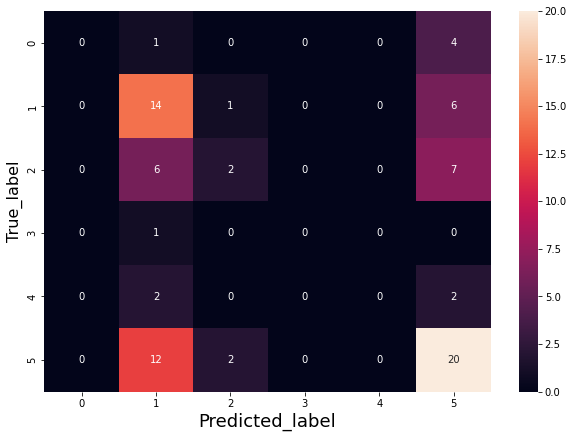

In [25]:
# Veiw confusion matrix of the the test data
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(test_Y.argmax(axis=1), Y_predict.argmax(axis=1))

#print(matrix)

df_cm = pd.DataFrame(matrix, index = [i for i in range(0,6)],
                  columns = [i for i in range(0,6)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('Predicted_label', fontsize=18)
plt.ylabel('True_label', fontsize=16)
#plt.savefig('Confusion_Matix/trainedon-lat_lon&rating&tag_tokens_activities.png')

In [71]:
tf.saved_model.save(model, 'question_field')

In [72]:
classification_model = tf.keras.models.load_model('question_field.h5', compile=False)

In [73]:
preds = classification_model.predict([train_encoded_question_types, train_actual_question_tokens, train_correct_statement_tokens])

In [74]:
for i in preds[:20]:
    max_index = np.argmax(i)
    print(classes[max_index])

Physics
Astronomy
Chemistry
Biology
Physics
Astronomy
Physics
Physics
Physics
Biology
Biology
Chemistry
Biology
Astronomy
Physics
Chemistry
Biology
Chemistry
Chemistry
Physics


In [75]:
import joblib as jl
from google.api_core.client_options import ClientOptions
import googleapiclient
import os

os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="thermal-works-298110-65274639ac90.json"

In [210]:
def tokenize_question(question_text):
    """Tokenize tags and add to dataframe

    # TODO: use a global to instantiate tokenizer
    
    """
    tokenizer = jl.load('artifacts/actual_question_tokenizer.bin')
    padded_tokens = []
    for tags in [question_text]:
        seqs = tokenizer.texts_to_sequences([tags])
        padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(seqs, 15, padding='post')
        padded_tokens.append(padded_seqs)
        
    # update df
    #df_emb['tag_tokens'] = padded_tokens
    
    return padded_tokens[0]

def classify_question(question):
    actual_question = tokenize_question(question)
    #print(actual_question.tolist()[0])
    correct_statement = np.array([[50,6,77,100,123]])
    #print(correct_statement)
    encoded_question_type = np.array([[0,0,1,0]])
    #print(encoded_question_type)
    
    return [{"question_type_encoding":encoded_question_type.tolist()[0], "question_tokens":actual_question.tolist()[0], "correct_statment_tokens":correct_statement.tolist()[0]}]
    preds = classification_model.predict([encoded_question_type, actual_question, correct_statement])
    #print(preds)
    for i in preds:
        max_index = np.argmax(i)
        print(classes[max_index])

In [211]:
classify_question('earth quakes can cause tsunamis')

[{'question_type_encoding': [0, 0, 1, 0],
  'question_tokens': [59, 12, 228, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'correct_statment_tokens': [50, 6, 77, 100, 123]}]

In [212]:
# Create the AI Platform service object.
# To authenticate set the environment variable
# GOOGLE_APPLICATION_CREDENTIALS=<path_to_service_account_file>
endpoint = 'https://europe-west1-ml.googleapis.com'
client_options = ClientOptions(api_endpoint=endpoint)
service = googleapiclient.discovery.build('ml', 'v1', client_options=client_options)


def predict_json(project, model, instances, version=None):
    """Send json data to a deployed model for prediction.

    Args:
        project (str): project where the AI Platform Model is deployed.
        model (str): model name.
        instances ([Mapping[str: Any]]): Keys should be the names of Tensors
            your deployed model expects as inputs. Values should be datatypes
            convertible to Tensors, or (potentially nested) lists of datatypes
            convertible to tensors.
        version: str, version of the model to target.
    Returns:
        Mapping[str: any]: dictionary of prediction results defined by the
            model.
    """
    name = 'projects/{}/models/{}'.format(project, model)

    if version is not None:
        name += '/versions/{}'.format(version)

    response = service.projects().predict(
        name=name,
        body={'instances': instances}
    ).execute()

    if 'error' in response:
        raise RuntimeError(response['error'])

    return response['predictions']

In [216]:
instances = classify_question('Our body has 11 organ systems')

preds = predict_json('thermal-works-298110', 'guess_the_field', instances, version='which_field')

for i in preds:
    max_index = np.argmax(i)
    print(classes[max_index])

Physics
